# Universidad Internacional de La Rioja  

### Máster Universitario en Visual Analytics and Big Data  

---

### **Predicción y Análisis de la Demanda y Suministro de Productos entre la Comunidad Andina y España**  
**Presentado por:** Danilo Andrés Beleño Villafañe  

---

### **Notebook 7: Modelado - Prueba Random Forest Regressor 1**  


In [141]:
from utils.bigquery_handler import BigQueryHandler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import joblib


In [142]:
bqh = BigQueryHandler('unir-predictiv0-andina-espana')

query = f"""
    SELECT 
        fecha, 
        anio, 
        mes, 
        tipo_movimiento_cod, 
        cod_pais, 
        cod_provincia, 
        cod_comunidad, 
        cod_taric, 
        dolares--, 
        --kilogramos
    FROM `unir-predictiv0-andina-espana.datacomex.comex_comunidad_andina_modelo` 
    WHERE nivel_taric = '1' AND tipo_movimiento_cod = 'I' AND cod_taric = '27' and dolares < 10000
"""

data = bqh.get_bigquery_data(query)

In [143]:
from utils.bigquery_handler import BigQueryHandler

bqh = BigQueryHandler('unir-predictiv0-andina-espana')

query = f"""
    WITH real_data AS (
        SELECT DISTINCT 
            cod_pais, 
            cod_provincia, 
            cod_taric,
            cod_comunidad,
            tipo_movimiento_cod
        FROM `unir-predictiv0-andina-espana.datacomex.comex_comunidad_andina_modelo`
        WHERE nivel_taric = '1' AND tipo_movimiento_cod = 'I' AND cod_taric = '27'
    )
    SELECT 
        DATE_ADD(DATE '2024-07-01', INTERVAL ROW_NUMBER() OVER() - 1 MONTH) as fecha, 
        cod_pais, 
        cod_provincia, 
        '27' as cod_taric
    FROM real_data
"""

bq_df = bqh.get_bigquery_data(query)

bq_df


,fecha,cod_pais,cod_provincia,cod_taric
0,2024-07-01,480,41,27
1,2024-08-01,480,04,27
2,2024-09-01,480,33,27
3,2024-10-01,480,30,27
4,2024-11-01,480,43,27
...,...,...,...,...
60,2029-07-01,500,17,27
61,2029-08-01,480,01,27
62,2029-09-01,480,38,27
63,2029-10-01,504,12,27


In [144]:
df = data.copy()

df['fecha'] = pd.to_datetime(df['fecha'])
df['fecha_ordinal'] = df['fecha'].map(lambda x: x.toordinal())

categorical_features = ["tipo_movimiento_cod", "cod_pais", "cod_provincia", "cod_comunidad", "cod_taric"]


encoder = OneHotEncoder(sparse_output=False, drop='first')
categoricals = df[categorical_features]
categoricals_encoded = encoder.fit_transform(categoricals)
categoricals_encoded_df = pd.DataFrame(
    categoricals_encoded, 
    columns=encoder.get_feature_names_out(categoricals.columns)
)


features = pd.concat([df[['fecha_ordinal']], categoricals_encoded_df], axis=1)
target = df['dolares']


In [145]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [146]:
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [147]:
y_pred = model.predict(X_test)

In [148]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 3036393.0234258813
R2 Score: 0.2807335379698098


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_3676\3165604944.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


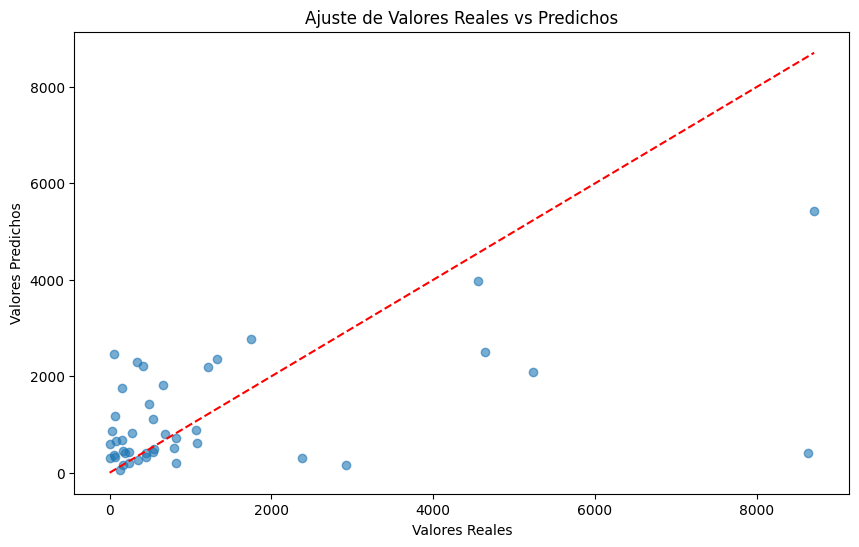

In [149]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Ajuste de Valores Reales vs Predichos')
plt.show()

In [150]:
joblib.dump(model, 'random_forest_regressor.pkl')
print("Modelo guardado como 'random_forest_regressor.pkl'")

Modelo guardado como 'random_forest_regressor.pkl'


## Guardaod

In [151]:
future_df1 = data.copy()

df_categorical = future_df1[categorical_features].drop_duplicates()
fechas_nuevas = pd.date_range(start='2024-07-01', end='2024-12-31', freq='MS')



df_fechas = pd.DataFrame({'fecha': fechas_nuevas})
df_combinado = df_categorical.merge(df_fechas, how='cross')

df_combinado['fecha'] = pd.to_datetime(df_combinado['fecha'])
df_combinado['mes'] = df_combinado['fecha'].dt.month
df_combinado['anio'] = df_combinado['fecha'].dt.year

future_data = df_combinado.copy() 


future_data['fecha_ordinal'] = future_data['fecha'].map(lambda x: x.toordinal())
future_categoricals = encoder.transform(future_data[categorical_features])
future_features = pd.concat(
    [future_data[['fecha_ordinal']], pd.DataFrame(future_categoricals, columns=encoder.get_feature_names_out())],
    axis=1
)

In [152]:
loaded_model = joblib.load('random_forest_regressor.pkl')
future_predictions = loaded_model.predict(future_features)

In [153]:
future_data['predicciones'] = future_predictions
print("Predicciones para fechas futuras:")
print(future_data[['fecha', 'predicciones']])

Predicciones para fechas futuras:
         fecha  predicciones
0   2024-07-01      446.8012
1   2024-08-01      446.8012
2   2024-09-01      446.8012
3   2024-10-01      446.8012
4   2024-11-01      446.8012
..         ...           ...
283 2024-08-01     1697.4510
284 2024-09-01     1697.4510
285 2024-10-01     1697.4510
286 2024-11-01     1697.4510
287 2024-12-01     1697.4510

[288 rows x 2 columns]


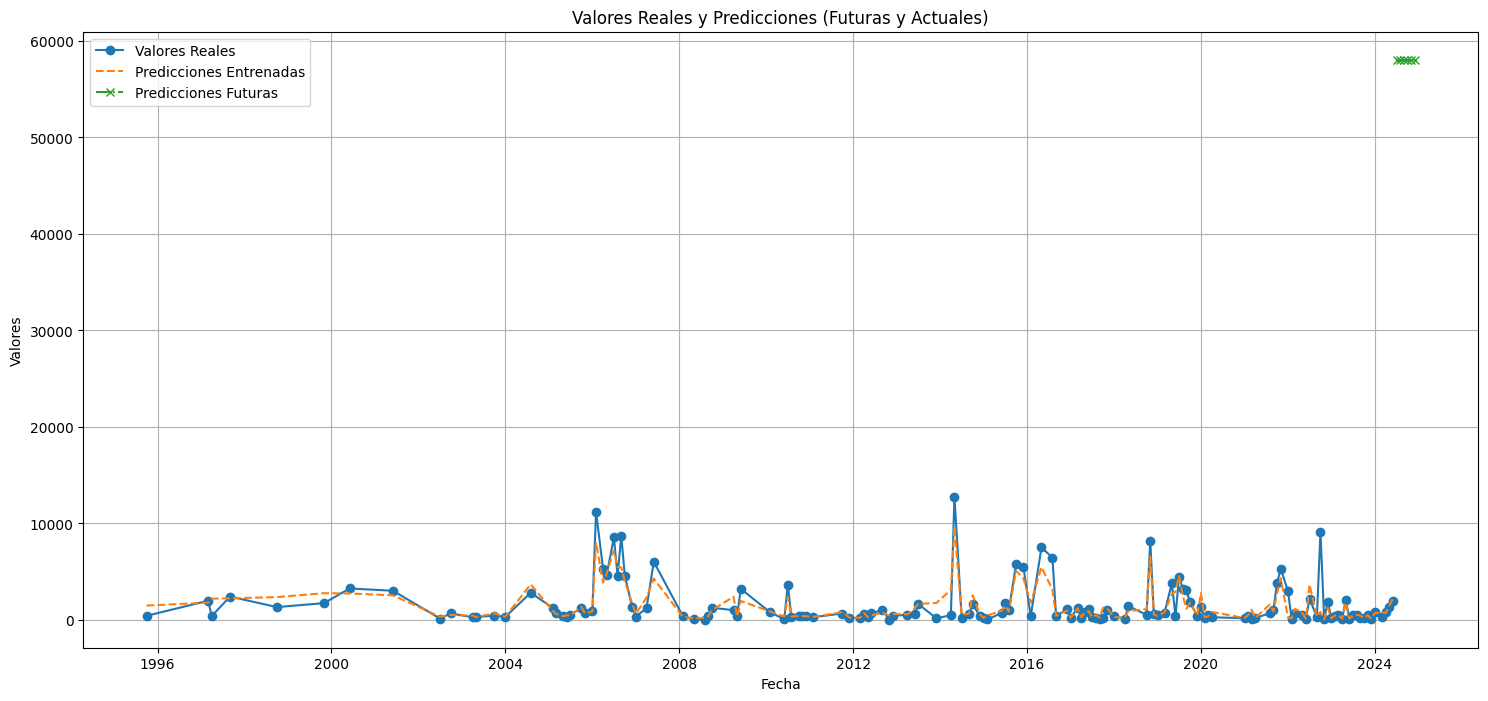

In [154]:

dates_all = pd.concat([data['fecha'], future_data['fecha']])
predictions_all = pd.concat([pd.Series(model.predict(features), index=data.index), future_data['predicciones']])
results_df = pd.DataFrame({'fecha': dates_all, 'predicciones': predictions_all})


data_grouped = data.groupby('fecha')['dolares'].sum().reset_index()
future_data_grouped = future_data.groupby('fecha')['predicciones'].sum().reset_index()


train_predictions_df = pd.DataFrame({'fecha': data['fecha'], 'predicciones': model.predict(features)})
train_predictions_df = train_predictions_df.groupby('fecha')['predicciones'].sum().reset_index()


plt.figure(figsize=(18, 8))
plt.plot(data_grouped['fecha'], data_grouped['dolares'], label='Valores Reales', marker='o')
plt.plot(train_predictions_df['fecha'], train_predictions_df['predicciones'], label='Predicciones Entrenadas', linestyle='--')
plt.plot(future_data_grouped['fecha'], future_data_grouped['predicciones'], label='Predicciones Futuras', linestyle='-.', marker='x')
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Valores Reales y Predicciones (Futuras y Actuales)')
plt.legend()
plt.grid()
plt.show()